# SWAN BOUNDSPEC SIDE

This notebooks shows examples of how to prescribe BOUNDSPEC SIDE spectral boundaries
using rompy boundary data objects.

Boundary of type `BOUNDSPEC SIDE` can be specified from existing spectral data using
the `rompy.swan.boundary.BoundspecSide` object. The boundary location is defined as the
middle point of a side of a specified grid object. The boundary spectra are defined by
interpolating or selecting (based on the nearest point) from the source spectra data at
that boundary location.

This class only supports `FILE` type boundary since the `PAR` type does not allow for
nonstationary boundary specification (`PAR` type boundary can be defined by using the
SWAN components if required).

We currently support `TPAR` and `SPEC2D` file types.


In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import wavespectra

from rompy.core.data import SourceFile
from rompy.core.time import TimeRange
from rompy.swan.grid import SwanGrid
from rompy.swan.boundary import BoundspecSide

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def read_tpar(tparfile):
    """Read SWAN TPAR files as a Dataframe."""
    df = pd.read_csv(
        tparfile,
        sep=" ",
        header=None,
        skiprows=1,
        parse_dates=[0],
        date_format="%Y%m%d.%H%M%S",
        index_col=0,
    )
    df.columns = ["hs", "tp", "dpm", "dspr"]
    return df


def get_color(cmap, value, vmin, vmax):
    """Return the HEX color for a value in a colormap."""
    cmap = matplotlib.cm.get_cmap(cmap)
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    return colors.rgb2hex(cmap(norm(value)))


def plot_boundary_side(dset, df, grid, time):
    """Plot side boundary stats.

    This function plots a snapshot of wave statistics from the source spectra dataset
    and the boundary wave stats generated for a grid from those spectra points.

    Parameters
    ----------
    dset: xr.Dataset
        Source spectra dataset used to define boundary from.
    df: pd.DataFrame
        Boundary time series defined from TPAR or SWAN ASCII file.
    grid: SwanGrid
        Grid object defining the SWAN domain.
    time: Datatime | str
        Time to plot.

    """
    # xb, yb = bnd._boundary_points(grid)
    xb = grid.x[:, 0]
    yb = grid.y[:, 0]

    fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 3.5))

    # Hs
    ax = axs[0]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.hs(), cmap="turbo", vmin=2.0, vmax=3.5)
    color = get_color("turbo", df.loc[time]["hs"], 2.0, 3.5)
    ax.plot(xb, yb, color=color, linewidth=4, zorder=10)
    plt.colorbar(p, label="Hs (m)")

    # Tp
    ax = axs[1]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.tp(), cmap="viridis", vmin=13.8, vmax=14.5)
    color = get_color("viridis", df.loc[time]["tp"], 13.8, 14.5)
    ax.plot(xb, yb, color=color, linewidth=4, zorder=10)
    plt.colorbar(p, label="Tp (s)")

    # Dpm
    ax = axs[2]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.dpm(), cmap="hsv", vmin=220, vmax=225)
    color = get_color("hsv", df.loc[time]["dpm"], 220, 225)
    ax.plot(xb, yb, color=color, linewidth=4, zorder=10)
    # ax.scatter(xb, yb, s=200, c=df.loc[time]["dpm"], marker=">", edgecolor="k", cmap="hsv", vmin=220, vmax=225)
    plt.colorbar(p, label="Dpm (deg)")

    for ax in axs:
        grid.plot(ax=ax, fscale=5)
        ax.set_extent([110.5, 115.5, -29.5, -23.5])
        ax.set_title(time)
        ax.coastlines()

In [8]:
datadir = Path("../../../tests/data")
modeldir = Path("model")
modeldir.mkdir(exist_ok=True)
workspace = Path(mkdtemp(dir="model"))

### Define rompy objects

Create instances of source, time and grid objects to use with the boundary classes

In [4]:
# source defines the dataset to be used to create the model boundary

source = SourceFile(
    uri=datadir / "aus-20230101.nc",
    kwargs=dict(engine="netcdf4"),
)
dset = source.open()
dset

<xarray.Dataset>
Dimensions:  (time: 5, site: 412, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T06:00:00 ... 2023-01-02
  * site     (site) int64 0 4 8 12 16 20 24 ... 1624 1628 1632 1636 1640 1644
  * freq     (freq) float32 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float32 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    lon      (site) float32 ...
    lat      (site) float32 ...
    efth     (time, site, freq, dir) float64 ...
    dpt      (time, site) float32 ...
    wspd     (time, site) float32 ...
    wdir     (time, site) float32 ...
Attributes: (12/16)
    product_name:           ww3.all_spec.nc
    area:                   Global 0.5 x 0.5 degree
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  n/a
    northernmost_latitude:  n/a
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2023-01-01 00:00:00
    stop_date:              2023-02-01 00:00:00
    field_type:             3-hourly

In [5]:
# times prescribe the times over which the model will run

times = TimeRange(start="2023-01-01T00", end="2023-01-02T00", interval="6h")
times

TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=21600), include_end=True)

In [6]:
# grid defines the model grid

grid = SwanGrid(x0=112, y0=-29, dx=0.5, dy=0.5, nx=8, ny=9, rot=20)
grid

SwanGrid: REG, 8x9

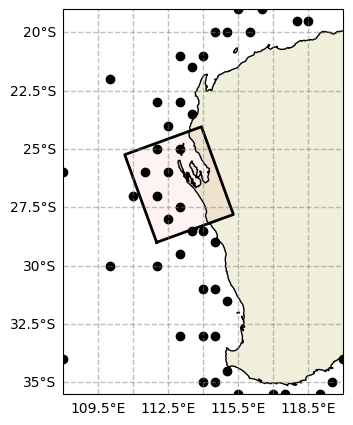

In [7]:
# Plot model grid and boundary points in the source spectra

fig, ax = grid.plot(fscale=5)
ax.plot(dset.lon, dset.lat, "ok")
ax.set_extent([108, 120, -35.5, -19])

### TPAR

Define a `BOUNDSPEC` type SWAN boundary with `TPAR` file by interpolating from the
source spectra dataset at the centre of the `WEST` side of the grid using the
*Inverse Distance Weighting* (`IDW`) sel method from wavespectra with a tolerance of 2
degrees within which at least three sites in the source spectra must exist (otherwise
missing values are returned).

In [9]:
bnd = BoundspecSide(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 2},
    location={"side": "west"},
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"cat {workspace / filename}");

BOUNDSPEC SIDE WEST CCW CONSTANT FILE fname='wa_tpar_west_000.bnd' seq=1

TPAR
20230101.000000 2.74 14.39 223.83 30.07
20230101.060000 2.80 14.03 223.88 31.27
20230101.120000 3.07 14.04 223.26 32.15
20230101.180000 3.48 14.17 223.08 33.61
20230102.000000 3.52 14.21 223.68 33.73


In [10]:
# Load the boundary created as a dataframe

df = read_tpar(workspace / filename)
df

,hs,tp,dpm,dspr
0,,,,
2023-01-01 00:00:00,2.74,14.39,223.83,30.07
2023-01-01 06:00:00,2.80,14.03,223.88,31.27
2023-01-01 12:00:00,3.07,14.04,223.26,32.15
2023-01-01 18:00:00,3.48,14.17,223.08,33.61
2023-01-02 00:00:00,3.52,14.21,223.68,33.73


Plot boundary stats, note the values weighted by the four nearest neighbours at the
centre of the `WEST` boundary

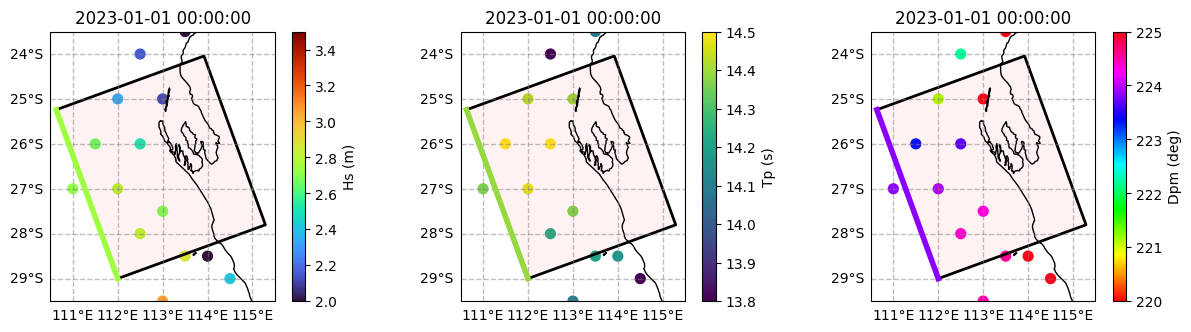

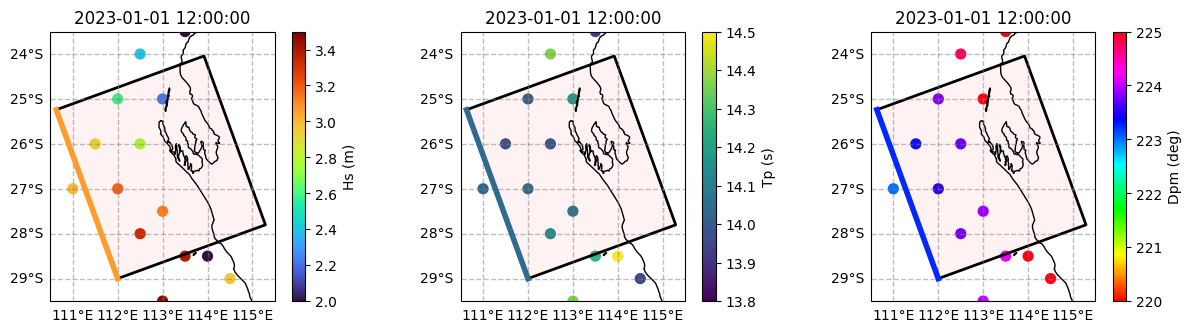

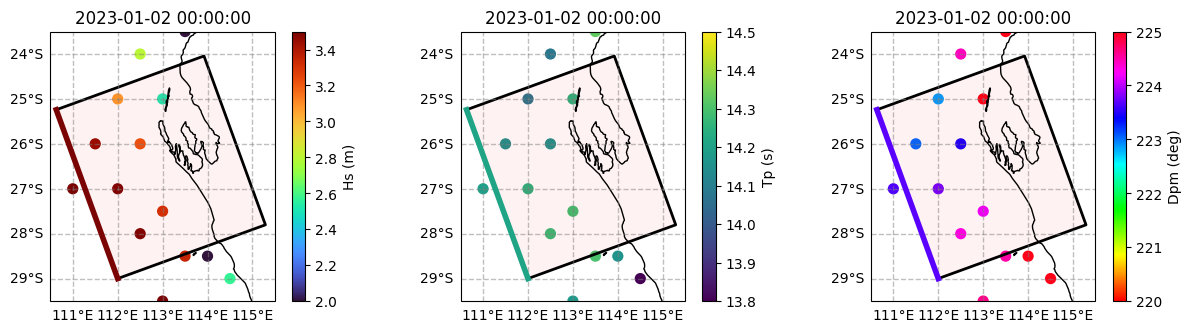

In [12]:
for time in df.index[::2]:
    plot_boundary_side(dset, df, grid, time)

### SPEC2D

Define a `BOUNDSPEC` type SWAN boundary with `SPEC2D` file by selecting from the source
spectra dataset at the centre of the `WEST` side of the grid using the
*nearest neighbour* (`nearest`) sel method from wavespectra with a tolerance of 2
degrees within which a site in the source spectra must exist (otherwise an exception is
raised).

In [13]:
bnd = BoundspecSide(
    id="wa",
    source=source,
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 2.0},
    location={"side": "west"},
    file_type="spec2d",
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"head -n 50 {workspace / filename}");

BOUNDSPEC SIDE WEST CCW CONSTANT FILE fname='wa_spec2d_west_000.bnd' seq=1

SWAN   1                                Swan standard spectral file
$   Created by wavespectra
$   
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
     1                                  number of locations
  111.000000  -27.000000
AFREQ                                   absolute frequencies in Hz
    11                                  number of frequencies
    0.05417
    0.05959
    0.06555
    0.07210
    0.07931
    0.08724
    0.09597
    0.10557
    0.11612
    0.12773
    0.14051
NDIR                                    spectral nautical directions in degr
     8                                  number of directions
     0.0000
    45.0000
    90.0000
   135.0000
   180.0000
   225.0000
   270.0000
   315.0000
QUANT
     1                                  numb

In [16]:
# Load the boundary created as a dataset

ds = wavespectra.read_swan(workspace / filename, as_site=True)
ds

<xarray.Dataset>
Dimensions:  (time: 5, site: 1, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T06:00:00 ... 2023-01-02
  * site     (site) <U18 'wa_spec2d_west_000'
  * freq     (freq) float64 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, site, freq, dir) float64 0.0 0.0 0.0 0.0 ... 0.01061 0.0 0.0
    lat      (site) float64 -27.0
    lon      (site) float64 111.0

In [17]:
# Calculate oundary stats from dataset for plotting

df = ds.isel(site=0, drop=True).spec.stats(["hs", "tp", "dpm", "dspr"]).to_pandas()
df

,hs,tp,dpm,dspr
time,,,,
2023-01-01 00:00:00,2.709378,14.361055,223.864182,31.245212
2023-01-01 06:00:00,2.799166,13.995838,223.720566,32.982870
2023-01-01 12:00:00,3.009826,14.025472,223.009888,33.819244
2023-01-01 18:00:00,3.453083,14.141555,222.878220,35.180063
2023-01-02 00:00:00,3.510868,14.194441,223.638062,35.336880


Plot boundary stats, note the values are identical to the nearest neighbour at the
centre of the `WEST` boundary

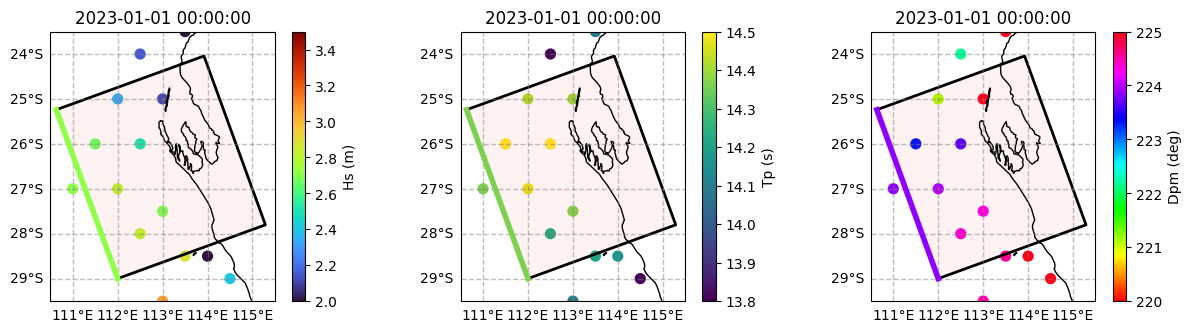

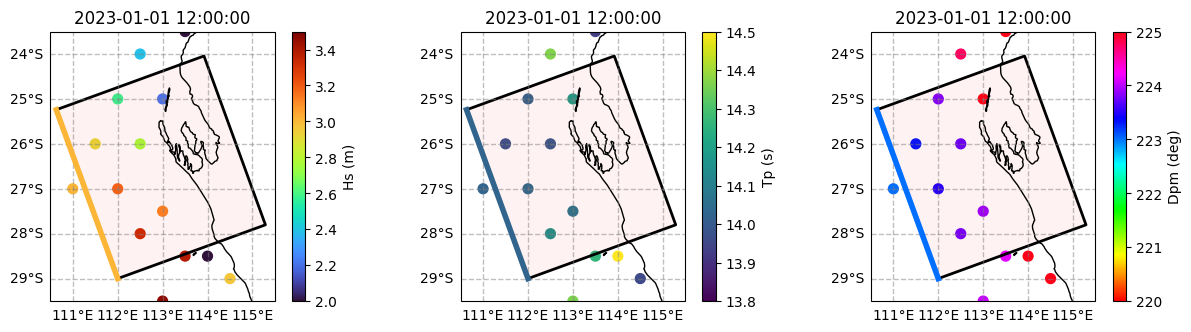

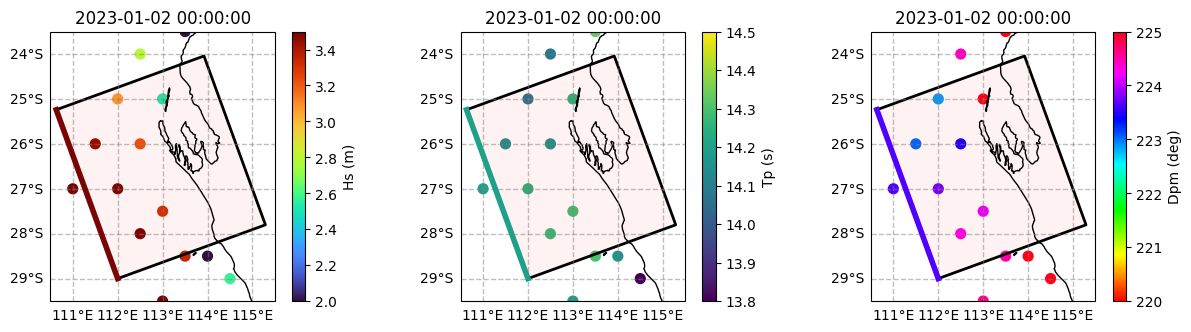

In [19]:
for time in df.index[::2]:
    plot_boundary_side(dset, df, grid, time)

### No nearest neighbours

When the `nearest` neighbour sel method is choosen there must be at least one site in
the source spectra within the radius defined by `tolerance` otherwise an exception is raised 

In [34]:
bnd = BoundspecSide(
    id="wa",
    source=source,
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 0.1},
    location={"side": "west"},
)

try:
    cmd = bnd.get(destdir=workspace, grid=grid, time=times)
except AssertionError as e:
    print(e)


Nearest site from (lat=-27.120614758428182, lon=111.31595971334866) is 0.338196 deg away but tolerance is 0.1 deg.


The `idw` sel method requires at least two neighbours within the radius defined by `tolerance`
however it does not raise an exception if those are not found but return missing values instead

In [35]:
bnd = BoundspecSide(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 0.1},
    location={"side": "west"},
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)

filename = f'{bnd.id}_{bnd.file_type}_{bnd.location.side}_000.bnd'
os.system(f"cat {workspace / filename}");

TPAR
20230101.000000 0.00 0.0 0.0 0.0
20230101.060000 0.00 0.0 0.0 0.0
20230101.120000 0.00 0.0 0.0 0.0
20230101.180000 0.00 0.0 0.0 0.0
20230102.000000 0.00 0.0 0.0 0.0
